In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 特徴量のリスト
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# データの読み込み
data = pd.read_csv('NSL-KDD/KDDTrain+.txt', sep=',', header=None, names=features)
target = data['label'].copy()
data.drop(["service", "land", "protocol_type", "flag", "is_host_login", "logged_in", "is_guest_login", "label", "difficulty"], axis=1, inplace=True)

# データの確認
print(data.head())
print(f"Data shape: {data.shape}")
print(f"Columns: {data.columns}")

   duration  src_bytes  dst_bytes  wrong_fragment  urgent  hot  \
0         0        491          0               0       0    0   
1         0        146          0               0       0    0   
2         0          0          0               0       0    0   
3         0        232       8153               0       0    0   
4         0        199        420               0       0    0   

   num_failed_logins  num_compromised  root_shell  su_attempted  ...  \
0                  0                0           0             0  ...   
1                  0                0           0             0  ...   
2                  0                0           0             0  ...   
3                  0                0           0             0  ...   
4                  0                0           0             0  ...   

   dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
0             150                  25                    0.17   
1             255                   1   

In [4]:
# trainデータを分割して学習データとテストデータに分ける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

Accuracy: 0.9975391617273497


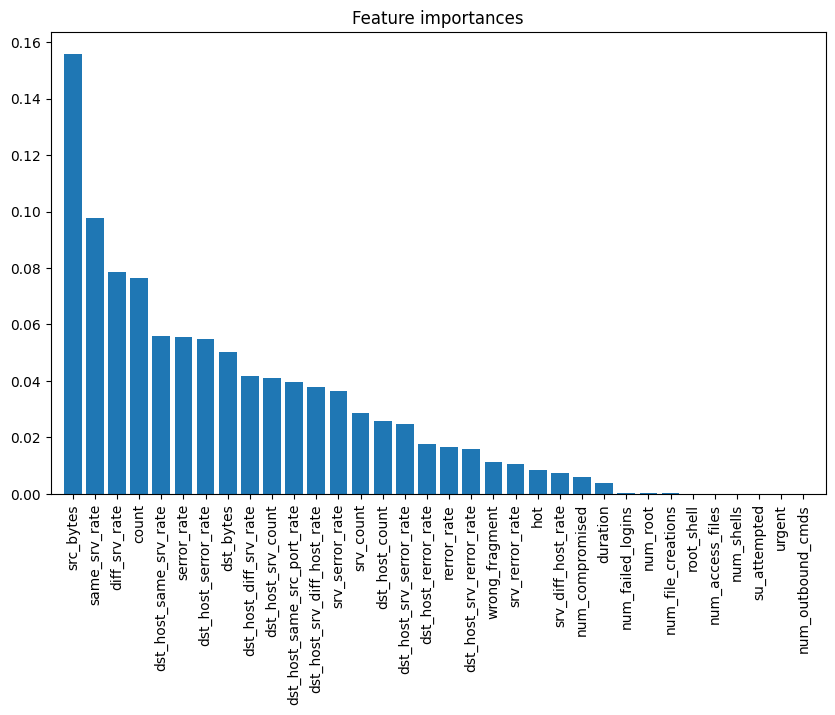

In [5]:
# 機械学習モデルの作成
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# numpy配列をDataFrameに変換
X_train = pd.DataFrame(X_train, columns=data.columns)
X_test = pd.DataFrame(X_test, columns=data.columns)

# ランダムフォレストの作成
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータでの精度
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# 特徴量の重要度
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), data.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [6]:
# ナイーブなiforest
from sklearn.ensemble import IsolationForest

# iforestのモデル作成
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# テストデータでの精度
y_pred = model.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)
y_test_iforest = np.where(y_test == "normal", 0, 1)
print(f"Accuracy: {accuracy_score(y_test_iforest, y_pred)}")


Accuracy: 0.56104466553768


In [7]:
# 異常と正常データに分割して、それぞれでモデルをトレーニング
y_train_iforest = np.where(y_train == "normal", 0, 1)
X_train_normal = X_train[y_train_iforest == 0]
X_train_anomaly = X_train[y_train_iforest == 1]
print(f"Normal data shape: {X_train_normal.shape}")
print(f"Anomaly data shape: {X_train_anomaly.shape}")

model_normal = IsolationForest(contamination=0.07, random_state=42)
model_anomaly = IsolationForest(contamination=0.3, random_state=42)

model_normal.fit(X_train_normal)
model_anomaly.fit(X_train_anomaly)

# テストデータでの精度
y_pred_normal = model_normal.predict(X_test)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

y_pred_anomaly = model_anomaly.predict(X_test)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

print(f"Normal Accuracy: {accuracy_score(y_test_iforest, y_pred_normal)}")
print(f"Anomaly Accuracy: {accuracy_score(y_test_iforest, y_pred_anomaly)}")


Normal data shape: (47260, 34)
Anomaly data shape: (40921, 34)
Normal Accuracy: 0.8924640135478408
Anomaly Accuracy: 0.83366850127011


In [8]:
# 不必要な特徴量を削除
important_features = importances > 0.01

X_test_dropped = X_test[data.columns[important_features]]
X_train_anomaly_dropped = X_train_anomaly[data.columns[important_features]]
X_train_normal_dropped = X_train_normal[data.columns[important_features]]

# モデルの作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

model_normal.fit(X_train_normal_dropped)
model_anomaly.fit(X_train_anomaly_dropped)

# テストデータでの精度
y_pred_normal = model_normal.predict(X_test_dropped)
y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

y_pred_anomaly = model_anomaly.predict(X_test_dropped)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

print(f"Normal Accuracy: {accuracy_score(y_test_iforest, y_pred_normal)}")
print(f"Anomaly Accuracy: {accuracy_score(y_test_iforest, y_pred_anomaly)}")

Normal Accuracy: 0.8856900931414056
Anomaly Accuracy: 0.5192104149026249


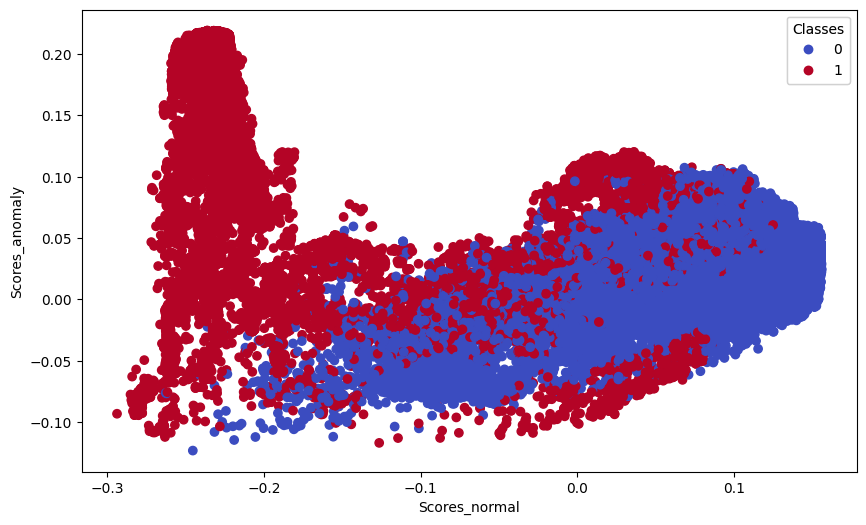

In [9]:
# K-meansクラスタリングでラベルを予測する
from sklearn.cluster import KMeans

# 教師データの異常スコアをプロット
X_train_dropped = X_train[data.columns[important_features]]
scores_train_normal = model_normal.decision_function(X_train_dropped)
scores_train_anomaly = model_anomaly.decision_function(X_train_dropped)
scores_train = np.column_stack((scores_train_normal, scores_train_anomaly))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores_train[:, 0], scores_train[:, 1], c=y_train_iforest, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

Scores shape: (37792, 2)
y_pred: [0 1 1 ... 0 0 0]
Accuracy: 0.9033657917019475


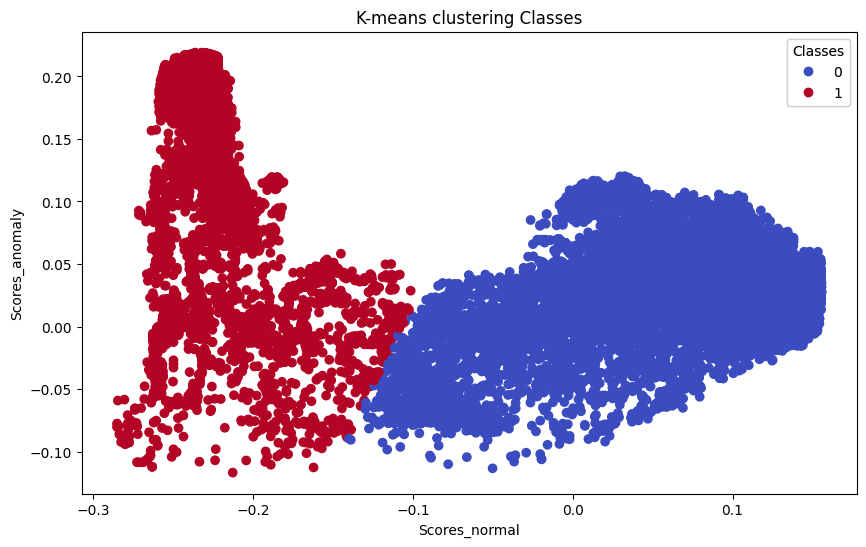

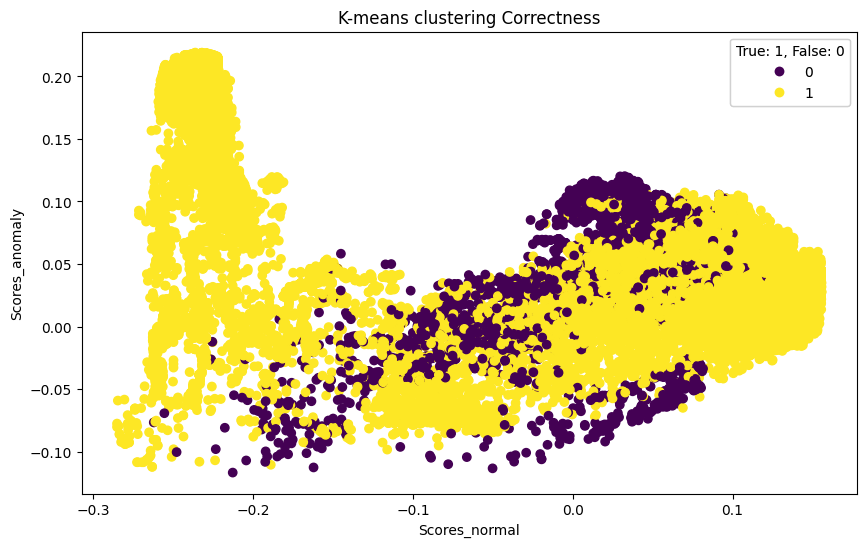

In [10]:
# アノマリスコアの取得
scores_normal = model_normal.decision_function(X_test_dropped)
scores_anomaly = model_anomaly.decision_function(X_test_dropped)

# クラスタリング
scores = np.column_stack((scores_normal, scores_anomaly))
print(f"Scores shape: {scores.shape}")
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(scores)
print(f"y_pred: {y_pred}")

# 精度の計算
print(f"Accuracy: {accuracy_score(y_test_iforest, y_pred)}")

# y_test_iforestと一致していないy_predにラベルをつける
labels = np.where(y_test_iforest == y_pred, 1, 0) # 1: 正解, 0: 不正解

# クラスをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("K-means clustering Classes")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

# ラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("K-means clustering Correctness")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()

y_pred: [0 1 1 ... 0 0 0]
Accuracy: 0.9374470787468248


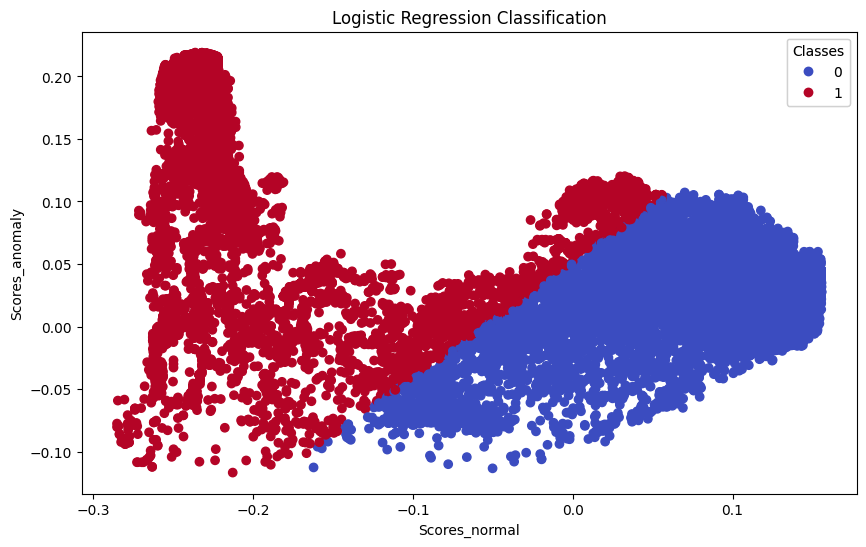

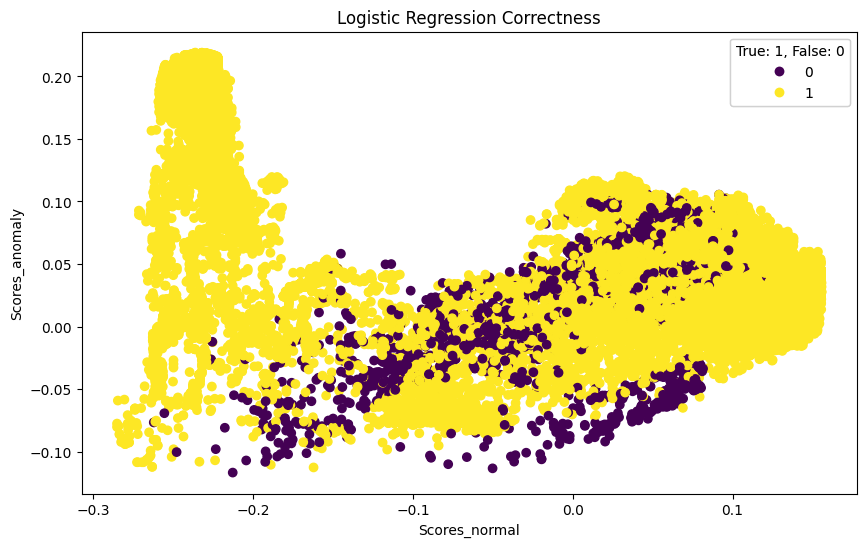

In [11]:
# ロジスティック回帰を用いてラベルを予測
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの作成
model_LR = LogisticRegression()
model_LR.fit(scores_train, y_train_iforest)

# ラベルの予測
y_pred = model_LR.predict(scores)
print(f"y_pred: {y_pred}")
print(f"Accuracy: {accuracy_score(y_test_iforest, y_pred)}")

# ラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Logistic Regression Classification")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

# 正答率をプロット
labels = np.where(y_test_iforest == y_pred, 1, 0) # 1: 正解, 0: 不正解

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Logistic Regression Correctness")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()


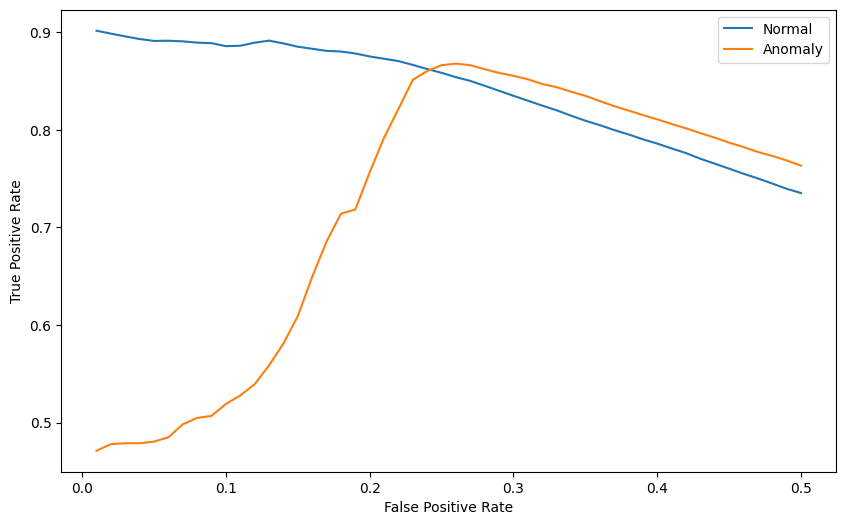

In [12]:
contaminations = np.linspace(0.01, 0.5, 50)
accuracies_normal = []
accuracies_anomaly = []

for contamination in contaminations:
    model_normal = IsolationForest(contamination=contamination, random_state=42)
    model_anomaly = IsolationForest(contamination=contamination, random_state=42)

    model_normal.fit(X_train_normal_dropped)
    model_anomaly.fit(X_train_anomaly_dropped)

    y_pred_normal = model_normal.predict(X_test_dropped)
    y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

    y_pred_anomaly = model_anomaly.predict(X_test_dropped)
    y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

    accuracy_normal = accuracy_score(y_test_iforest, y_pred_normal)
    accuracies_normal.append(accuracy_normal)
    accuracy_anomaly = accuracy_score(y_test_iforest, y_pred_anomaly)
    accuracies_anomaly.append(accuracy_anomaly)


plt.figure(figsize=(10, 6))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(contaminations, accuracies_normal, label="Normal")
plt.plot(contaminations, accuracies_anomaly, label="Anomaly")
plt.legend()
plt.show()

In [13]:
def calculate_fpr_tpr(y_true, y_pred):
    # 真陽性、偽陽性、真陰性、偽陰性の初期化
    TP = FP = TN = FN = 0

    # 真陽性、偽陽性、真陰性、偽陰性の計算
    for i in range(len(y_true)):
        if y_true[i] == 1:  # 実際のクラスが1の場合
            if y_pred[i] == 1:
                TP += 1
            else:
                FN += 1
        else:  # 実際のクラスが0の場合
            if y_pred[i] == 1:
                FP += 1
            else:
                TN += 1

    # FPRとTPRの計算
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)

    return FPR, TPR

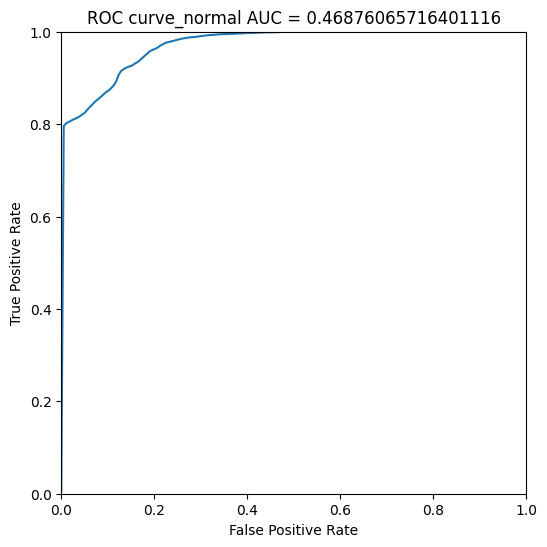

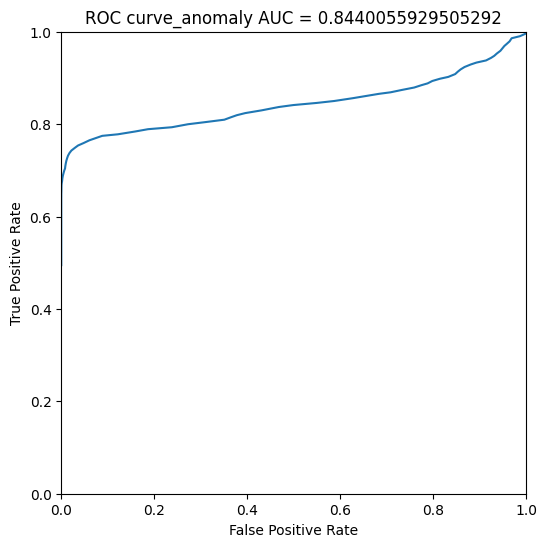

In [14]:
# contamination ratioに対するfpr, tpr, thresholdを計算
contaminations = np.linspace(0.00001, 0.5, 100)
fprs_normal, tprs_normal, thresholds_normal = [], [], []
fprs_anomaly, tprs_anomaly, thresholds_anomaly = [], [], []


for contamination in contaminations:
    model_normal = IsolationForest(contamination=contamination, random_state=42)
    model_anomaly = IsolationForest(contamination=contamination, random_state=42)

    model_normal.fit(X_train_normal_dropped)
    model_anomaly.fit(X_train_anomaly_dropped)

    y_pred_normal = model_normal.predict(X_test_dropped)
    y_pred_normal = np.where(y_pred_normal == -1, 1, 0)

    y_pred_anomaly = model_anomaly.predict(X_test_dropped)
    y_pred_anomaly = np.where(y_pred_anomaly == -1, 0, 1)

    # fpr, tprを計算
    FPR, TPR = calculate_fpr_tpr(y_test_iforest, y_pred_normal)
    fprs_normal.append(FPR)
    tprs_normal.append(TPR)
    thresholds_normal.append(contamination)

    FPR, TPR = calculate_fpr_tpr(y_test_iforest, y_pred_anomaly)
    fprs_anomaly.append(FPR)
    tprs_anomaly.append(TPR)
    thresholds_anomaly.append(contamination)
                
# AUCを計算
from sklearn.metrics import auc
auc_normal = auc(fprs_normal, tprs_normal)
auc_anomaly = auc(fprs_anomaly, tprs_anomaly)


plt.figure(figsize=(6, 6))
plt.title(f"ROC curve_normal AUC = {auc_normal}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fprs_normal, tprs_normal)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(6, 6))
plt.title(f"ROC curve_anomaly AUC = {auc_anomaly}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fprs_anomaly, tprs_anomaly)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()